<a href="https://colab.research.google.com/github/adsamaz/Chattbot/blob/remove-unwanted-data/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chatbot ETA
In the course Neural networks and learning machines (D7046E) this sentimentanalys network was created. 

Made by:
Ivar Rockström,
Niklas Ulfvarson,
Adam Sawert,
Rebecka Mattsson and
Niklas Dahlquist

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from collections import Counter



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounts a google drive folder which contains orginal databse with reviews from amazon. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Imports the database as datafram using the Pandas library. Our database contains around two hundred thousand reviews for different video games on amazon. All reviews are rated on the scale 1 to 5, where 5 is the most positive and 1 the most negative. 

The goal with our network is to classify if a text is postivt or negtive and not to have a scale from 1 to 5. Therefore we removed all reviews with a score of 3. The we set all reviews with a score of 1 and 2 as negative (score = 0). Reviews with a score of 4 or 5 where set to positive (score = 1).

Then we clean all text from special charachters and numbers. We also removes all words that not appear more then 15 times in all reviews.

In [0]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/drive/My Drive/Chatbot_shared/reviews_Video_Games_5.json.gz')

In [4]:
#Removes everything in except the review and overall score. Then removes
# all reviews with an score of 3 beacuse of them being natrual when we set all
#score under 3 to 0(negative) and score over 3 to 1(positive)
#df=data
df=df.get(['reviewText','overall'])
df=df[df.overall != 3.0] 
df=df.replace(1.0, 0)
df=df.replace(2.0, 0)
df=df.replace(4.0, 1)
df=df.replace(5.0, 1)
reviews = df.reviewText
score = df.overall

# Removes special characters, numberts etc
reviews = reviews.str.lower()
reviews = reviews.replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
reviews = reviews.replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
reviews = reviews.str.replace('[^\w\s]','')                                                       # remove special characters
reviews = reviews.replace('\d', '', regex=True)                                                   # remove numbers


#Tokenizer
all_text = ' '.join(reviews)          # Makes on string of all texts.
words = all_text.split()

#Count all the words
count_words = Counter(words)          # Creats a counter function

# Sort words after which is most common
total_words = len(words)
sorted_words = count_words.most_common(total_words)

print(len(sorted_words))

#Creats a vocabulary where 
i=0
minimum_word_count = 15
vocab_s=[]
for x in sorted_words:
  if x[1] > minimum_word_count:
    vocab_few.append((x[0],x[1]))
    i=i+1


,reviewText,overall
0,Installing the game was a struggle (because of...,0.0
1,If you like rally cars get this game you will ...,1.0
2,1st shipment received a book instead of the ga...,0.0
4,I had Dirt 2 on Xbox 360 and it was an okay ga...,1.0
5,"Overall this is a well done racing game, with ...",1.0
...,...,...
231775,Funny people on here are rating sellers that a...,1.0
231776,All this is is the Deluxe 32GB Wii U with Mari...,0.0
231777,The package should have more red on it and sho...,0.0
231778,Can get this at Newegg for $329.00 and the pac...,0.0


In [6]:
print(reviews)

0         installing the game was a struggle because of ...
1         if you like rally cars get this game you will ...
2         st shipment received a book instead of the gam...
4         i had dirt  on xbox  and it was an okay game i...
5         overall this is a well done racing game with v...
                                ...                        
231775    funny people on here are rating sellers that a...
231776    all this is is the deluxe gb wii u with mario ...
231777    the package should have more red on it and sho...
231778    can get this at newegg for  and the packaging ...
231779    this is not real you can go to any retail stor...
Name: reviewText, Length: 203505, dtype: object


In [7]:
#Tokenizer
all_text = ' '.join(reviews)          # Makes on string of all texts.
words = all_text.split()

#Count all the words
count_words = Counter(words)          # Creats a counter function

# Sort words after which is most common
total_words = len(words)
sorted_words = count_words.most_common(total_words)

print(len(sorted_words))

484154


In [0]:
i=0
vocab_few=[]
for x in sorted_words:
  if x[1] > 15:
    vocab_few.append((x[0],x[1]))
    i=i+1

In [9]:
print(len(vocab_few))
vocab_few[30000:30316]

30329


[('az', 16),
 ('thingit', 16),
 ('predatory', 16),
 ('repeatthe', 16),
 ('inarguably', 16),
 ('funive', 16),
 ('squishing', 16),
 ('edgeofyourseat', 16),
 ('shallowness', 16),
 ('busses', 16),
 ('thoughti', 16),
 ('moneymaking', 16),
 ('battlesystem', 16),
 ('differencei', 16),
 ('spreadsheet', 16),
 ('diligently', 16),
 ('marveled', 16),
 ('hoyle', 16),
 ('reviewive', 16),
 ('whilebut', 16),
 ('mercantile', 16),
 ('hii', 16),
 ('dismissing', 16),
 ('isso', 16),
 ('equips', 16),
 ('chews', 16),
 ('commenter', 16),
 ('foolproof', 16),
 ('tak', 16),
 ('goingi', 16),
 ('gamesfirst', 16),
 ('upone', 16),
 ('aimbots', 16),
 ('kira', 16),
 ('luther', 16),
 ('frayed', 16),
 ('visualizations', 16),
 ('cis', 16),
 ('gameplease', 16),
 ('goodcons', 16),
 ('ocassional', 16),
 ('tiduss', 16),
 ('hasi', 16),
 ('enraptured', 16),
 ('groupthe', 16),
 ('futurama', 16),
 ('combot', 16),
 ('hobo', 16),
 ('disorient', 16),
 ('enoughbut', 16),
 ('onetwo', 16),
 ('campground', 16),
 ('overlooks', 16),
 ('p

In [10]:
# Creats a vocabulary where each number corresponds to a word.

vocab_to_int = {w:i+1 for i, (w,c) in enumerate(vocab_few)}

# Changes all word in reviews to interger values accoriding to vocab_to_int
reviews_int = []
for review in reviews:
  r=[]
  for w in review.split():
    try:
      r.append(vocab_to_int[w])
    except:
      continue
  reviews_int.append(r)
print (reviews_int[0:3])


[[3001, 1, 9, 23, 4, 3790, 77, 5, 29, 14, 1044, 443, 5063, 1029, 2, 471, 24, 59, 25, 1418, 70, 410, 73, 20, 48, 3075, 3, 1, 9, 8, 1199, 759, 1240, 53, 1, 9, 23, 74, 8, 69, 27, 1, 542, 13, 8, 19, 3, 214, 1658, 3, 214, 12807, 1108, 64, 1078, 12, 1, 1347, 32, 76, 641, 3, 2601, 8, 6039, 10, 12, 1, 2171, 2, 23122, 145, 3, 114, 188, 7835, 9, 103, 51, 1227, 5, 633, 383, 29, 960, 3, 36, 34, 1075, 41, 11281, 9341, 4383, 2, 7, 163, 3, 7, 14, 849, 34, 286, 28, 7, 405, 10, 25, 233, 3, 915, 10, 20, 1620], [28, 7, 27, 4383, 471, 36, 11, 9, 7, 43, 19, 14223, 6, 37, 3928, 3, 4789, 1080, 152, 192, 12, 2664, 39, 205, 4, 314, 4383, 223, 552, 208, 10, 6, 49, 4789, 2, 65, 1, 1435, 41, 1, 9, 49, 2289, 226, 205, 1, 89, 17, 10, 284, 35, 640], [1238, 10604, 1293, 4, 964, 299, 5, 1, 10604, 129, 4, 3653, 33, 9, 1961, 16, 4, 472, 896, 1056, 18, 6067, 594, 8, 129, 12, 3121, 16, 7835, 2, 1481, 73, 1964, 5, 1, 1440, 2, 1, 555, 42, 285, 254, 42, 24, 60, 22, 4, 3653, 10, 52, 7887]]


In [11]:
encoded_labels = np.array(score)
encoded_labels

array([0., 1., 0., ..., 0., 0., 0.])

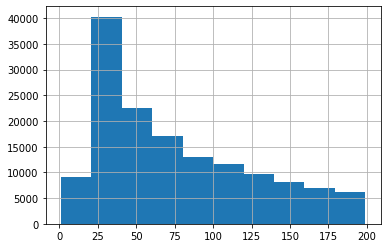

count    144482.000000
mean         75.325210
std          50.383753
min           1.000000
25%          32.000000
50%          61.000000
75%         110.000000
max         199.000000
dtype: float64

In [14]:
#Prints a visualisation of how many word there are in each review
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [13]:
# Removes all reviews which have zero words in them.

reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if (l>0 and l<200) ]
encoded_labels = [ encoded_labels[i] for i, l in enumerate(reviews_len) if (l> 0 and l<200) ]
print(len(reviews_int))
print(len(encoded_labels))

144482
144482


In [0]:
# Fucntion which zero padds and shortens all reviews to seq_length

def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review        
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features


In [16]:
features = np.array(pad_features(reviews_int,200))
features[10][:200]
print(len(features[10][:200]))

200


In [17]:
# SPlitting data into training, validation and testing
split_frac = 0.5
len_feat=len(features)
encoded_labels = np.array(encoded_labels)

train_x = features[0:int(split_frac*len_feat)]
train_y = encoded_labels[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = encoded_labels[int(split_frac*len_feat):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]


type(train_y)

numpy.ndarray

In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data. removes last incomplete batch
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [19]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) 
# batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) 
# batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,     4,  2677,     9],
        [    0,     0,     0,  ...,     4,  2066,   133],
        [    0,     0,     0,  ...,    16,    34,  2954],
        ...,
        [    0,     0,     0,  ...,   363,    27,    58],
        [    0,     0,     0,  ...,    55,    30, 24845],
        [    0,     0,     0,  ...,     3,     1,  6530]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       dtype=torch.float64)


In [0]:
from gensim.models import KeyedVectors

# Load embeddings from the pre-trained file
# The file can be found in Canvas and must be placed in the same directory as the notebook)
fastText_embeddings = KeyedVectors.load_word2vec_format('/content/drive/My Drive/Chatbot_shared/wiki.simple.vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#Creating own embeddinglayer # TEEEEST
emb_dim = 300  #Embedding dim
matrix_len = len(sorted_words)
weights_matrix = np.zeros((matrix_len, 300))
words_found = 0

for i, word in enumerate(sorted_words):
    try: 
        weights_matrix[i] = fastText_embeddings[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

print(weights_matrix.shape)
print(len(sorted_words))      

NameError: ignored

In [0]:
word='sweden'
#print(words[0])
test1=fastText_embeddings['sweden']
test2=fastText_embeddings['norway']

print(len(test1))
from scipy import spatial

result = 1 - spatial.distance.cosine(test1, test2)

print(result)

fastText_embeddings.most_similar(positive=['sweden'])

print(fastText_embeddings.wv.vectors.shape)

weights = torch.FloatTensor(fastText_embeddings.vectors)

print(weights)


300
0.597154974937439
(111051, 300)
tensor([[ 0.2892, -0.4608,  0.3514,  ...,  0.1331, -0.2347,  0.0053],
        [ 0.0569, -0.0520,  0.2733,  ..., -0.0695, -0.1606, -0.0989],
        [ 0.2013,  0.0104,  0.1623,  ..., -0.0931, -0.1408, -0.1326],
        ...,
        [ 0.2377, -0.0403, -0.0326,  ..., -0.0606,  0.0348, -0.2974],
        [ 0.5376, -0.2263,  0.0231,  ...,  0.0800, -0.3782, -0.2765],
        [ 0.1598,  0.0028, -0.2026,  ..., -0.0032, -0.1265, -0.1526]])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


In [22]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [0]:


class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [0]:
vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 200
hidden_dim = 256
n_layers = 2

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [37]:
from tqdm import tqdm
epochs = 10
counter = 0
print_every = 6
clip = 5
valid_loss_min = np.Inf
# Create a list to keep track of how the loss changes
train_losses = []
validate_losses = []

model.train()
for i in (range(epochs)):
    h = model.init_hidden(batch_size)

    # A variable for containing the sum of all batch losses for this epoch
    train_loss = 0
    validate_loss = 0

    
    #Train step
    counter = 0
    for inputs, labels in (train_loader):
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        train_loss += loss.item()
        print(
            '\rEpoch {} [{}/{}] - Loss: {}'.format(
                i+1, counter, len(train_loader), loss
            ),
            end=''
        )
    print('\n')


    #Validation Step
    counter = 0
    val_h = model.init_hidden(batch_size)
    val_losses = []
    model.eval()
    for inp, lab in valid_loader:
        counter += 1
        val_h = tuple([each.data for each in val_h])
        inp, lab = inp.to(device), lab.to(device)
        out, val_h = model(inp, val_h)
        val_loss = criterion(out.squeeze(), lab.float())
        val_losses.append(val_loss.item())
        validate_loss += val_loss.item()
        print(
            '\rValidation of Epoch {} [{}/{}] - Loss: {}'.format(
                i+1, counter, len(valid_loader), val_loss
            ),
            end=''
        )
    print('\n')

    #Append the epoch loss to the list of losses
    train_losses.append(train_loss/len(train_loader))
    validate_losses.append(validate_loss/len(valid_loader))
        
    model.train()
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...\n'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)

Epoch 1 [1444/1444] - Loss: 0.17117202281951904

Validation of Epoch 1 [722/722] - Loss: 0.2654053270816803

Validation loss decreased (inf --> 0.183190).  Saving model ...

Epoch 2 [1444/1444] - Loss: 0.17723394930362701

Validation of Epoch 2 [722/722] - Loss: 0.22424547374248505

Validation loss decreased (0.183190 --> 0.175977).  Saving model ...

Epoch 3 [1444/1444] - Loss: 0.2890533208847046

Validation of Epoch 3 [722/722] - Loss: 0.19392776489257812

Validation loss decreased (0.175977 --> 0.173861).  Saving model ...

Epoch 4 [1444/1444] - Loss: 0.2225295603275299

Validation of Epoch 4 [722/722] - Loss: 0.1174258440732956

Epoch 5 [1444/1444] - Loss: 0.12482292950153351

Validation of Epoch 5 [722/722] - Loss: 0.15691205859184265

Epoch 6 [1444/1444] - Loss: 0.053149789571762085

Validation of Epoch 6 [722/722] - Loss: 0.0830165222287178

Epoch 7 [1444/1444] - Loss: 0.05901377648115158

Validation of Epoch 7 [722/722] - Loss: 0.17677420377731323

Epoch 8 [1444/1444] - Loss: 0

In [38]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.170
Test accuracy: 93.752%


Results


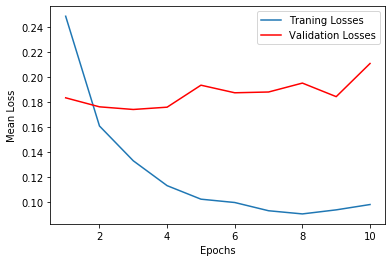

722

In [39]:
# Plot the mean training and validation loss per epoch

print("Results")

line1 = plt.plot(range(1,epochs+1),train_losses,label='Traning Losses')
line2 = plt.plot(range(1,epochs+1),validate_losses,'r',label='Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend()
plt.show()

len(val_losses)

In [65]:
## THIS IS FOR TESTING YOUR OWN SENTENCES. 

# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))


test_input =[]
test_input.append('i think this model was good to use')
test_int = []
for test_temp in test_input:
    r = [vocab_to_int[w] for w in test_temp.split()]
    test_int.append(r)
print (test_int[0:3])

h = model.init_hidden(1)

features = np.array(pad_features(test_int,200))

features = torch.from_numpy(features)

model.eval()

h = tuple([each.data for each in h])
inputs = features.to(device)
output, h = model(inputs, h)

print(output)

[[8, 124, 11, 1331, 23, 52, 3, 97]]
tensor(0.9413, device='cuda:0', grad_fn=<SelectBackward>)
